# New Clue
In this notebook, we'll test the new, simplified base CLUE implementation. We're not using Bayesian Neural Networks here, so the uncertainty is just the entropy of the classifier.

## Setup


Import libraries

In [1]:
import importlib
import models.regene_models as regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import clue.simple_base_clue as simple_base_clue
importlib.reload(simple_base_clue)

<module 'clue.simple_base_clue' from '/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/clue/simple_base_clue.py'>

Set the device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [4]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Set the latent dimension

In [5]:
latent_dim = 256

Create a models directory if it doesn't exist

In [6]:
# Create models directory if it doesn't exist
os.makedirs('../model_saves', exist_ok=True)
model_saves_path = '../model_saves'

## Load models and prepare data

### Load models

In [9]:
from models.mnist_classifier import MNISTClassifier
from models.mnist_vae import VAE

classifier = MNISTClassifier(device=device)
vae = VAE(latent_dim=latent_dim, device=device)

classifier.load_state_dict(torch.load(os.path.join(model_saves_path, 'mnist_classifier.pth'), map_location=device))
vae.load_state_dict(torch.load(os.path.join(model_saves_path, 'mnist_vae.pth'), map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_17903/91868577.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(os.path.j

<All keys matched successfully>

### Get most uncertain images
Here we find the data points in the test set that result in the highest uncertainty predictions.

In [13]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all test data points
uncertainties = []
indices = []

classifier.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get latent representations and predictions
        logits = classifier(images)
        
        # Calculate uncertainty (entropy) for each prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        # Store uncertainties and indices
        uncertainties.extend(entropy.cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(testset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

We then plot the top 20 most uncertain predictions.

In [14]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        testset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = testset[data_idx]
        
        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
        
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")
    
    plt.suptitle("Most Uncertain Predictions")
    plt.show()

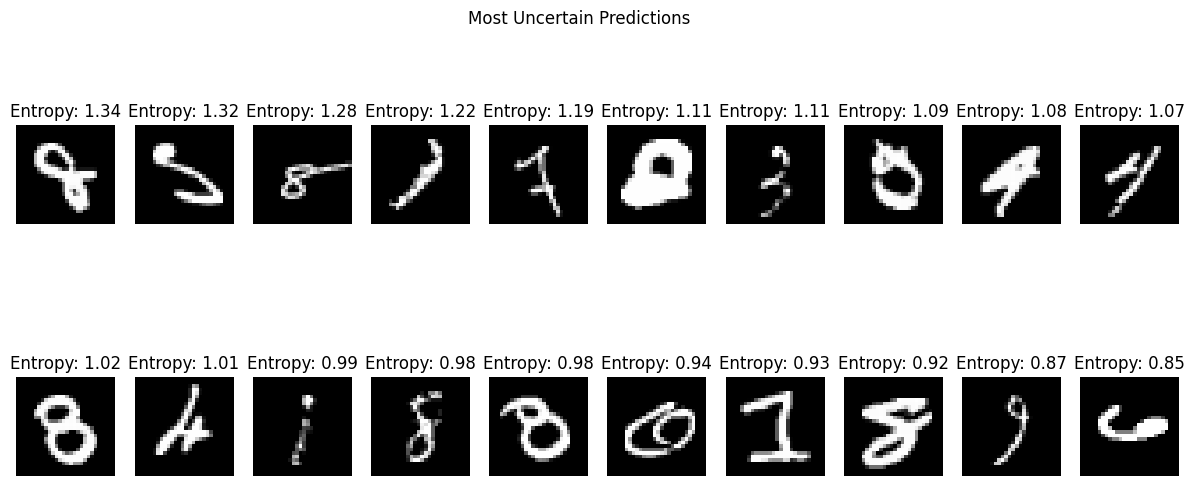

In [15]:
# Plot the most uncertain predictions
plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=20)

## Test new CLUE implementation
Let's test the CLUE implementation on one image first. We'll show the difference between the original image, the reconstructed image, and the counterfactual image.

Step 00: Loss: 0.1889, Entropy: 0.1889, Distance: 0.0000
Step 01: Loss: 0.1927, Entropy: 0.0327, Distance: 1.6000
Step 02: Loss: 0.2047, Entropy: 0.0140, Distance: 1.9070
Step 03: Loss: 0.2021, Entropy: 0.0080, Distance: 1.9411
Step 04: Loss: 0.1947, Entropy: 0.0062, Distance: 1.8851
Step 05: Loss: 0.1835, Entropy: 0.0056, Distance: 1.7796
Step 06: Loss: 0.1698, Entropy: 0.0055, Distance: 1.6421
Step 07: Loss: 0.1563, Entropy: 0.0058, Distance: 1.5046
Step 08: Loss: 0.1468, Entropy: 0.0063, Distance: 1.4051
Step 09: Loss: 0.1425, Entropy: 0.0067, Distance: 1.3580
Step 10: Loss: 0.1410, Entropy: 0.0071, Distance: 1.3390
Step 11: Loss: 0.1389, Entropy: 0.0074, Distance: 1.3153
Step 12: Loss: 0.1352, Entropy: 0.0078, Distance: 1.2741
Step 13: Loss: 0.1302, Entropy: 0.0082, Distance: 1.2203
Step 14: Loss: 0.1251, Entropy: 0.0086, Distance: 1.1646
Step 15: Loss: 0.1203, Entropy: 0.0090, Distance: 1.1124
Step 16: Loss: 0.1160, Entropy: 0.0096, Distance: 1.0636
Step 17: Loss: 0.1119, Entropy:

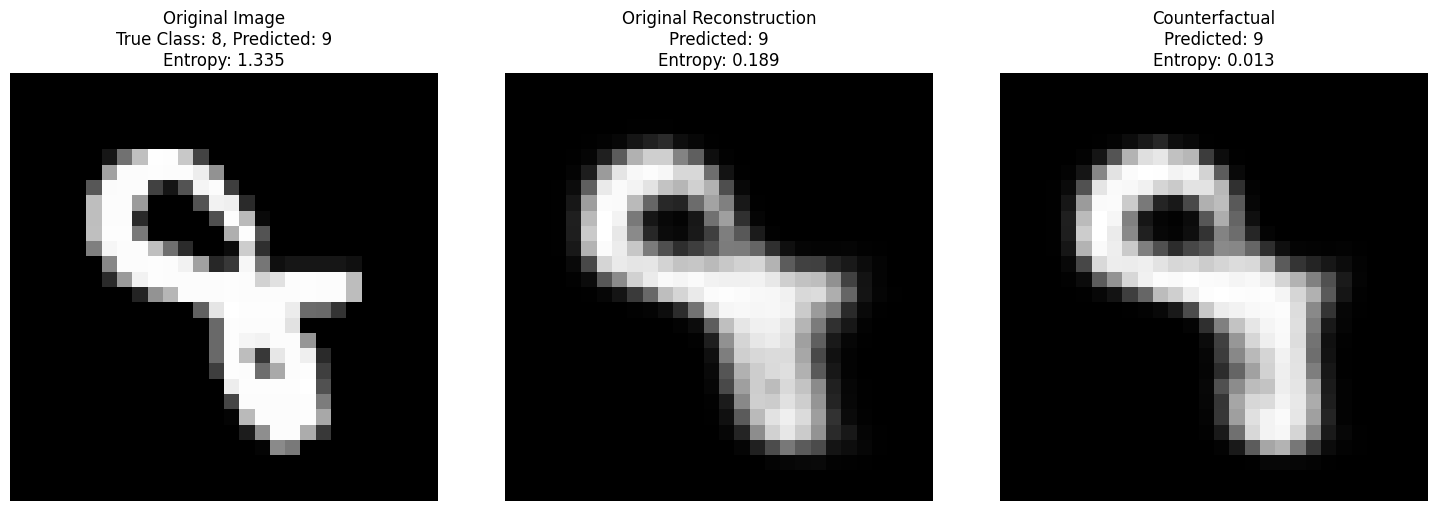

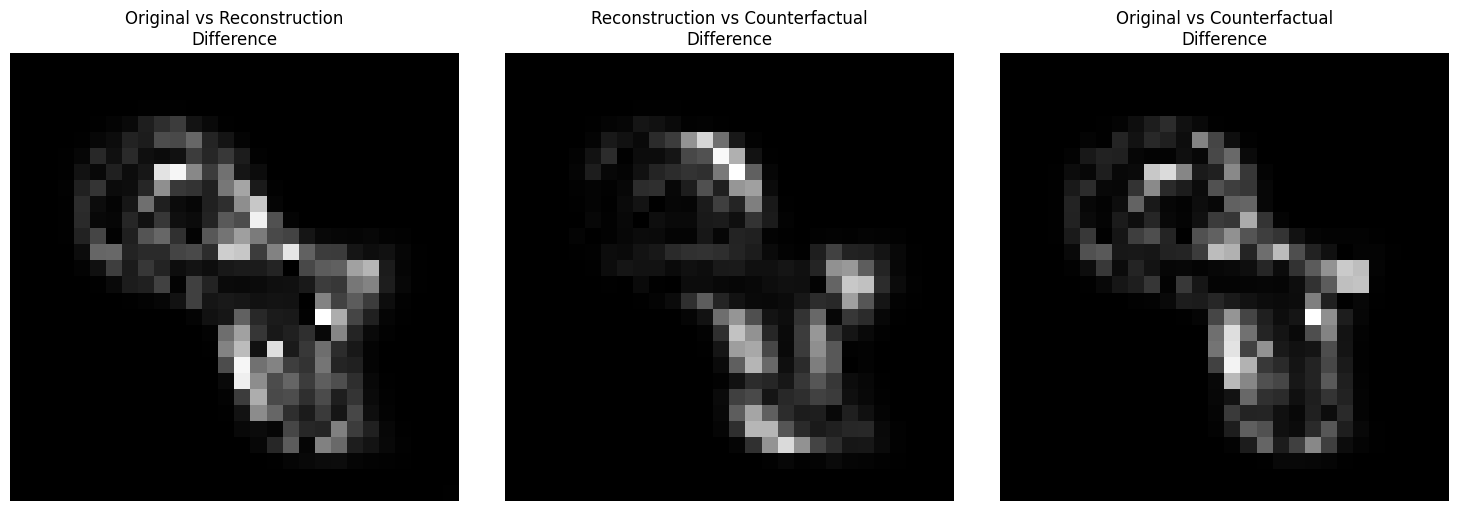


Class probabilities:
Original (True class: 8, Predicted: 9): [0.    0.    0.009 0.    0.326 0.    0.    0.099 0.209 0.357]
Reconstruction (Predicted: 9): [0.    0.    0.    0.    0.041 0.    0.    0.001 0.001 0.957]
Explained (Predicted: 9): [0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.998]


In [29]:
import importlib
import clue.simple_base_clue as simple_base_clue
importlib.reload(simple_base_clue)
from clue.simple_base_clue import SimpleCLUE

# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[0]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation and original prediction entropy
classifier.eval()
vae.eval()
with torch.no_grad():
    z0, _ = vae.encode(uncertain_image)
    # Get original image prediction and entropy
    original_logits = classifier(uncertain_image)
    original_probs = torch.nn.functional.softmax(original_logits, dim=1)
    original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
    original_pred = torch.argmax(original_probs, dim=1).item()

# Initialize CLUE
clue = SimpleCLUE(
    vae=vae,
    classifier=classifier,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.1,
    lr=0.1,
    device=device
)

# Optimize to find explanation
z_explained = clue.optimize(steps=20)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = vae.decode(z0)
    # CLUE reconstruction  
    clue_recon = vae.decode(z_explained)
    
    # Get predictions and uncertainties for reconstructions
    recon_logits = classifier(original_recon)
    explained_logits = classifier(clue_recon)
    
    recon_probs = torch.nn.functional.softmax(recon_logits, dim=1)
    explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
    
    recon_entropy = -(recon_probs * torch.log(recon_probs + 1e-10)).sum()
    explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()

    # Get predicted classes
    recon_pred = torch.argmax(recon_probs, dim=1).item()
    explained_pred = torch.argmax(explained_probs, dim=1).item()

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy:.3f}')
plt.axis('off')

plt.subplot(132)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Original Reconstruction\nPredicted: {recon_pred}\nEntropy: {recon_entropy:.3f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy:.3f}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot differences
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(torch.abs(uncertain_image[0,0].cpu() - original_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Original vs Reconstruction\nDifference')
plt.axis('off')

plt.subplot(132)
plt.imshow(torch.abs(original_recon[0,0].cpu().detach() - clue_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Reconstruction vs Counterfactual\nDifference')
plt.axis('off')

plt.subplot(133)
plt.imshow(torch.abs(uncertain_image[0,0].cpu() - clue_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Original vs Counterfactual\nDifference')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print(f"Original (True class: {true_label}, Predicted: {original_pred}):", original_probs.cpu().numpy()[0].round(3))
print(f"Reconstruction (Predicted: {recon_pred}):", recon_probs.cpu().numpy()[0].round(3))
print(f"Explained (Predicted: {explained_pred}):", explained_probs.cpu().numpy()[0].round(3))

Next let's run CLUE on 20 images and plot the results.

Step 00: Loss: 0.1889, Entropy: 0.1889, Distance: 0.0000
Step 01: Loss: 0.0647, Entropy: 0.0327, Distance: 1.6000
Step 02: Loss: 0.0606, Entropy: 0.0101, Distance: 2.5255
Step 03: Loss: 0.0664, Entropy: 0.0035, Distance: 3.1461
Step 04: Loss: 0.0730, Entropy: 0.0018, Distance: 3.5579
Step 05: Loss: 0.0777, Entropy: 0.0012, Distance: 3.8230
Step 06: Loss: 0.0805, Entropy: 0.0009, Distance: 3.9817
Step 07: Loss: 0.0819, Entropy: 0.0007, Distance: 4.0604
Step 08: Loss: 0.0822, Entropy: 0.0006, Distance: 4.0779
Step 09: Loss: 0.0815, Entropy: 0.0005, Distance: 4.0482
Step 10: Loss: 0.0802, Entropy: 0.0005, Distance: 3.9822
Step 11: Loss: 0.0783, Entropy: 0.0005, Distance: 3.8888
Step 12: Loss: 0.0761, Entropy: 0.0005, Distance: 3.7758
Step 13: Loss: 0.0736, Entropy: 0.0006, Distance: 3.6493
Step 14: Loss: 0.0709, Entropy: 0.0006, Distance: 3.5143
Step 15: Loss: 0.0682, Entropy: 0.0007, Distance: 3.3742
Step 16: Loss: 0.0654, Entropy: 0.0007, Distance: 3.2315
Step 17: Loss: 0.0626, Entropy:

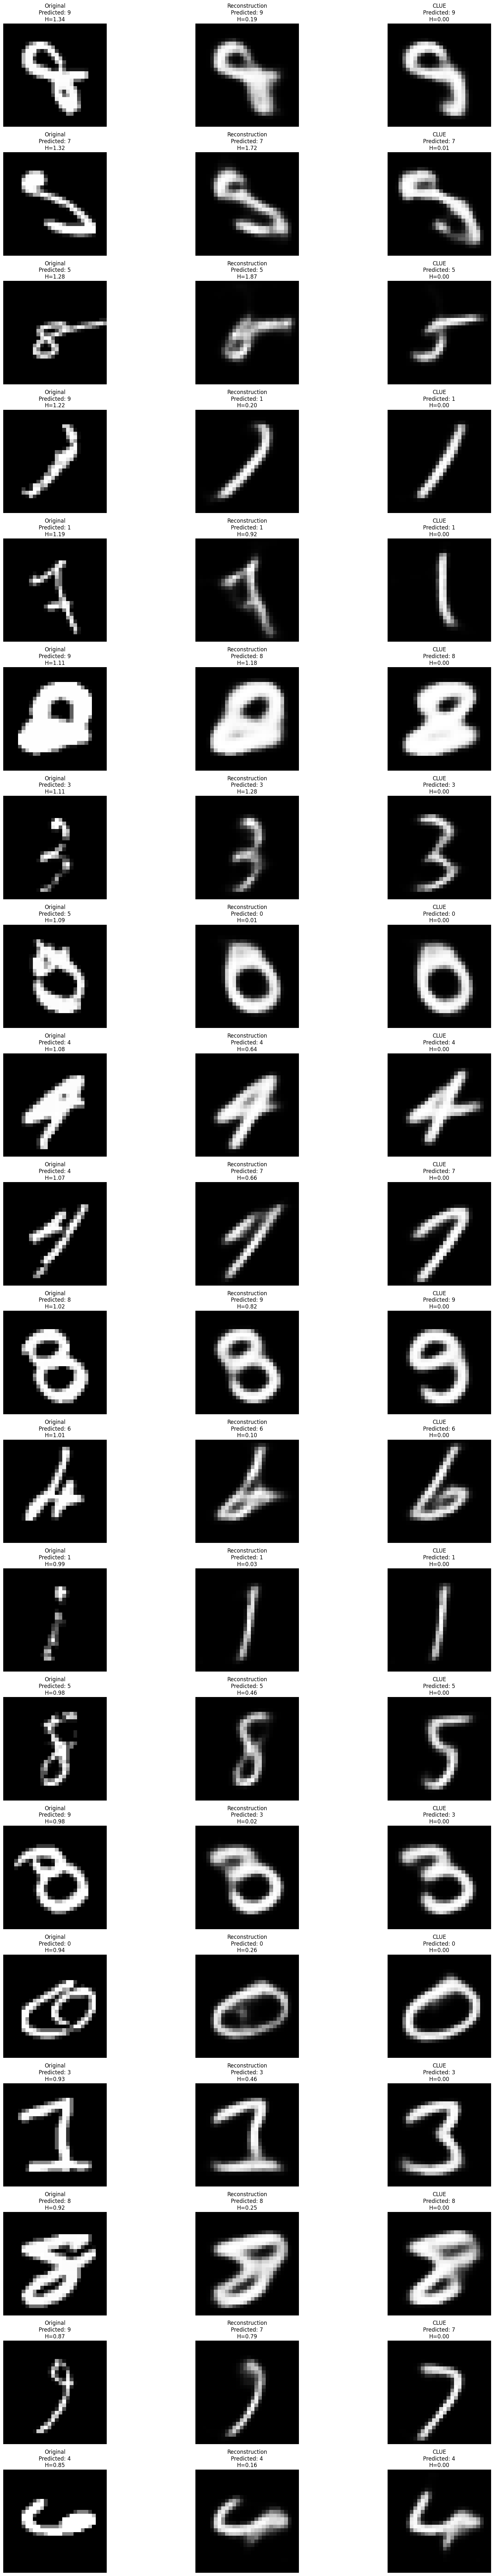


Class probabilities for last example:
Original (Class 4): [0.001 0.    0.126 0.    0.755 0.    0.059 0.    0.018 0.041]
Reconstruction (Class 4): [0.    0.    0.002 0.    0.967 0.    0.001 0.    0.002 0.029]
Explained (Class 4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [30]:
# Import and reload modules
import importlib
import clue.simple_base_clue as simple_base_clue
importlib.reload(simple_base_clue)
from clue.simple_base_clue import SimpleCLUE

# Get 20 most uncertain images and generate CLUEs for each
plt.figure(figsize=(20, 80))  # Increased height significantly to give more space per row

for i in range(20):
    # Get uncertain image and its latent representation
    uncertain_idx = sorted_data_indices[i]
    uncertain_image, _ = testset[uncertain_idx]
    uncertain_image = uncertain_image.to(device).unsqueeze(0)

    # Get latent representation and original predictions
    classifier.eval()
    vae.eval()
    with torch.no_grad():
        z0, _ = vae.encode(uncertain_image)
        # Get predictions for original image
        original_logits = classifier(uncertain_image)
        original_probs = torch.nn.functional.softmax(original_logits, dim=1)
        original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
        original_class = torch.argmax(original_probs).item()

    # Initialize and run CLUE
    clue = SimpleCLUE(
        vae=vae,
        classifier=classifier,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.02,
        lr=0.1,
        device=device
    )
    z_explained = clue.optimize(steps=20)

    # Generate reconstructions
    with torch.no_grad():
        original_recon = vae.decode(z0)
        clue_recon = vae.decode(z_explained)
        
        # Get predictions and uncertainties for reconstructions
        recon_logits = classifier(original_recon)
        explained_logits = classifier(clue_recon)
        recon_probs = torch.nn.functional.softmax(recon_logits, dim=1)
        explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
        recon_entropy = -(recon_probs * torch.log(recon_probs + 1e-10)).sum()
        explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()
        
        # Get predicted classes
        recon_class = torch.argmax(recon_probs).item()
        explained_class = torch.argmax(explained_probs).item()

    # Plot this example
    plt.subplot(20, 3, 3*i+1)
    plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
    plt.title(f'Original\nPredicted: {original_class}\nH={original_entropy:.2f}', fontsize=12)
    plt.axis('off')

    plt.subplot(20, 3, 3*i+2)
    plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
    plt.title(f'Reconstruction\nPredicted: {recon_class}\nH={recon_entropy:.2f}', fontsize=12)
    plt.axis('off')

    plt.subplot(20, 3, 3*i+3)
    plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
    plt.title(f'CLUE\nPredicted: {explained_class}\nH={explained_entropy:.2f}', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities for last example
print("\nClass probabilities for last example:")
print("Original (Class {}):".format(original_class), original_probs.cpu().numpy()[0].round(3))
print("Reconstruction (Class {}):".format(recon_class), recon_probs.cpu().numpy()[0].round(3))
print("Explained (Class {}):".format(explained_class), explained_probs.cpu().numpy()[0].round(3))

In [32]:
# Import and reload modules
import importlib
import clue.simple_base_clue as simple_base_clue
importlib.reload(simple_base_clue)
from clue.simple_base_clue import SimpleCLUE

# Initialize lists to store entropies and classes
original_entropies = []
recon_entropies = []
counterfactual_entropies = []
class_agreements = []  # Track when original and counterfactual predict same class

for i in range(20):
    # Get uncertain image and its latent representation
    uncertain_idx = sorted_data_indices[i]
    uncertain_image, _ = testset[uncertain_idx]
    uncertain_image = uncertain_image.to(device).unsqueeze(0)

    # Get latent representation and original predictions
    classifier.eval()
    vae.eval()
    with torch.no_grad():
        z0, _ = vae.encode(uncertain_image)
        # Get predictions for original image
        original_logits = classifier(uncertain_image)
        original_probs = torch.nn.functional.softmax(original_logits, dim=1)
        original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
        original_class = torch.argmax(original_probs).item()
        original_entropies.append(original_entropy.item())

    # Initialize and run CLUE
    clue = SimpleCLUE(
        vae=vae,
        classifier=classifier,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.02,
        lr=0.1,
        device=device
    )
    z_explained = clue.optimize(steps=20)

    # Generate reconstructions and get their entropies
    with torch.no_grad():
        original_recon = vae.decode(z0)
        clue_recon = vae.decode(z_explained)
        
        # Get predictions and uncertainties for reconstructions
        recon_logits = classifier(original_recon)
        explained_logits = classifier(clue_recon)
        recon_probs = torch.nn.functional.softmax(recon_logits, dim=1)
        explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
        recon_entropy = -(recon_probs * torch.log(recon_probs + 1e-10)).sum()
        explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()
        
        # Get predicted classes
        explained_class = torch.argmax(explained_probs).item()
        
        recon_entropies.append(recon_entropy.item())
        counterfactual_entropies.append(explained_entropy.item())
        
        # Track class agreement
        class_agreements.append(original_class == explained_class)

# Calculate averages
avg_original_entropy = sum(original_entropies) / len(original_entropies)
avg_recon_entropy = sum(recon_entropies) / len(recon_entropies)
avg_explained_entropy = sum(counterfactual_entropies) / len(counterfactual_entropies)
class_agreement_rate = sum(class_agreements) / len(class_agreements)

print(f"\nResults over {len(original_entropies)} images:")
print(f"Entropies:")
print(f"\tAverage original entropy: {avg_original_entropy:.3f}")
print(f"\tAverage reconstruction entropy: {avg_recon_entropy:.3f}")
print(f"\tAverage counterfactual entropy: {avg_explained_entropy:.3f}\n")
print(f"Differences:")
print(f"\tTotal average reduction in entropy (original - counterfactual): {avg_original_entropy - avg_explained_entropy:.3f}")
print(f"\tAverage reduction in entropy from reconstruction (original - reconstruction): {avg_original_entropy - avg_recon_entropy:.3f}")
print(f"\tAverage reduction in entropy from counterfactual (reconstruction - counterfactual): {avg_recon_entropy - avg_explained_entropy:.3f}\n")
print(f"Class agreement rate: {class_agreement_rate:.2%}")

Step 00: Loss: 0.1889, Entropy: 0.1889, Distance: 0.0000
Step 01: Loss: 0.0647, Entropy: 0.0327, Distance: 1.6000
Step 02: Loss: 0.0606, Entropy: 0.0101, Distance: 2.5255
Step 03: Loss: 0.0664, Entropy: 0.0035, Distance: 3.1461
Step 04: Loss: 0.0730, Entropy: 0.0018, Distance: 3.5579
Step 05: Loss: 0.0777, Entropy: 0.0012, Distance: 3.8230
Step 06: Loss: 0.0805, Entropy: 0.0009, Distance: 3.9817
Step 07: Loss: 0.0819, Entropy: 0.0007, Distance: 4.0604
Step 08: Loss: 0.0822, Entropy: 0.0006, Distance: 4.0779
Step 09: Loss: 0.0815, Entropy: 0.0005, Distance: 4.0482
Step 10: Loss: 0.0802, Entropy: 0.0005, Distance: 3.9822
Step 11: Loss: 0.0783, Entropy: 0.0005, Distance: 3.8888
Step 12: Loss: 0.0761, Entropy: 0.0005, Distance: 3.7758
Step 13: Loss: 0.0736, Entropy: 0.0006, Distance: 3.6493
Step 14: Loss: 0.0709, Entropy: 0.0006, Distance: 3.5143
Step 15: Loss: 0.0682, Entropy: 0.0007, Distance: 3.3742
Step 16: Loss: 0.0654, Entropy: 0.0007, Distance: 3.2315
Step 17: Loss: 0.0626, Entropy: